# **Problem 2: Variational Autoencoders on Poor Sevens**

In [ ]:
import pickle
import librosa
import random
import pandas as pd
import numpy as np
import torch
import itertools
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F
from torchvision.datasets import MNIST
import torch.utils.data as utils
from torch.utils.data import TensorDataset, DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
train_files = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/HW4/hw4_tr7.pkl', 'rb'))
test_files = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/HW4/hw4_te7.pkl', 'rb'))

# print shape
print(train_files.shape, test_files.shape)
print(type(train_files))

(6265, 28, 28) (1028, 28, 28)
<class 'numpy.ndarray'>


In [ ]:
train_loader = DataLoader(torch.Tensor(train_files).to(device), batch_size=128, shuffle=True)
test_loader = DataLoader(torch.Tensor(test_files).to(device), batch_size=128)

print("check train loader")
print(len(train_loader))
a = next(iter(train_loader))
print(a[0].shape, len(a))

print("\ncheck test loader")
print(len(test_loader))
a = next(iter(train_loader))
print(a[0].shape)

check train loader
49
torch.Size([28, 28]) 128

check test loader
9
torch.Size([28, 28])


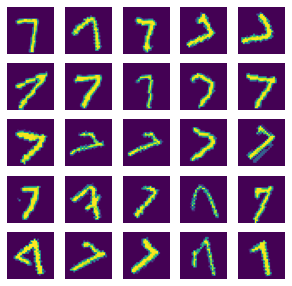

In [ ]:
# visualize the data
fig,axes = plt.subplots(nrows = 5, ncols = 5, figsize=(5,5))
i = 0
for n in range(5):
    for j in range(5):
        axes[n, j].imshow(train_files[i])
        axes[n, j].axis('off')
        i += 1
fig.show()

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.mu = nn.Linear(256, K)
        self.var = nn.Linear(256, K)
        self.fc3 = nn.Linear(K, 256)
        self.fc4 = nn.Linear(256, 512)
        self.fc5 = nn.Linear(512, 784)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
        
    def encode(self, x):
        x = F.relu(self.fc1(x))
        h1 = F.relu(self.fc2(x))
        mu = self.mu(h1)
        variable = self.var(h1)
        return mu, variable

    def decode(self, z):
        z = F.relu(self.fc3(z))
        z = F.relu(self.fc4(z))
        z = torch.sigmoid(self.fc5(z))
        return z

    def forward(self, x):
        x = x.view(x.size(0), -1)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        z = self.decode(z)
        return z, mu, logvar

In [ ]:
# below chunck of code is borrowed from:
# https://github.com/pytorch/examples/issues/399

def err_func(recon_x, x, mu, logvar):
    x = x.view(x.size(0), -1)
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [ ]:
K = 4
model = AutoEncoder()
model.to(device)

print(model)

optimizer = optim.Adam(model.parameters(), lr=5e-5)

AutoEncoder(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (mu): Linear(in_features=256, out_features=4, bias=True)
  (var): Linear(in_features=256, out_features=4, bias=True)
  (fc3): Linear(in_features=4, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=512, bias=True)
  (fc5): Linear(in_features=512, out_features=784, bias=True)
)


In [ ]:
model.train()
epochs = 600
for e in range(1, epochs+1):
    train_loss = 0    
    for data in train_loader:

        optimizer.zero_grad()

        recon_batch, mu, logvar = model(data)

        # calculate scalar loss
        loss = err_func(recon_batch, data, mu, logvar)
        
        # calculate the gradient of the loss
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    
    tloss = round(train_loss / len(train_loader), 4)
    if e % 50 == 0:
        print('Epoch: {eps}  |  Train Loss: {tl}'.format(eps=e, tl=tloss ))

Epoch: 50  |  Train Loss: 16797.8335
Epoch: 100  |  Train Loss: 15473.9842
Epoch: 150  |  Train Loss: 14977.4186
Epoch: 200  |  Train Loss: 14577.1704
Epoch: 250  |  Train Loss: 14296.5058
Epoch: 300  |  Train Loss: 14084.0997
Epoch: 350  |  Train Loss: 13929.4258
Epoch: 400  |  Train Loss: 13795.9067
Epoch: 450  |  Train Loss: 13689.2799
Epoch: 500  |  Train Loss: 13597.2978
Epoch: 550  |  Train Loss: 13519.5557
Epoch: 600  |  Train Loss: 13447.7646


In [ ]:
# discussed this part with a classmate, as I was confused on how to form random vectors. Code is Implemented on my own.
model.eval()
with torch.no_grad():
    out, mu, var = model(train_loader.dataset.data[0].unsqueeze(0))

dimen = np.arange(-5, 5.0, 0.5)
# sampling from normal distribution
vector = np.random.normal(loc = mu.cpu().numpy(), scale = np.exp(0.5 * var.cpu().numpy()), size = (1, K))
random_vector = []
# forming random code vector
for i in range(len(dimen)):
    random_vector.append(vector.squeeze())
random_vector = np.array(random_vector)
print(random_vector.shape)

(20, 4)


In [ ]:
dimension_samples_list = []
with torch.no_grad(): # since we need to get the output from the decoder
    for i in range(K): # no.of dimensions
        random_vector_copy = np.copy(random_vector)
        random_vector_copy[:, i] = dimen # setting a particular dimension with dimen
        dimension_samples_list.append(model.decode( torch.Tensor(random_vector_copy).to(device)).cpu().numpy() )
print(len(dimension_samples_list))

4


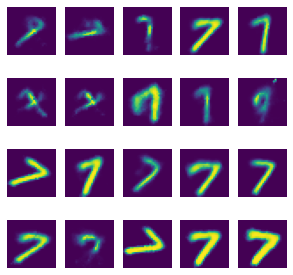

In [ ]:
# visualizing some random generated samples
vector = torch.randn(len(dimen), K)
with torch.no_grad():
    examples = model.cpu().decode(vector)
examples = examples.detach().numpy().reshape(-1, 28,28)
fig,axes = plt.subplots(nrows = 4, ncols = 5, figsize=(5,5))
i = 0
for n in range(4):
    for j in range(5):
        axes[n, j].imshow(examples[i].squeeze())
        axes[n, j].axis('off')
        i += 1
fig.show()

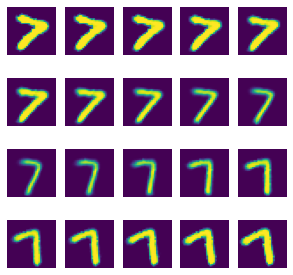

In [ ]:
# fixing dimension 1
outs = dimension_samples_list[0]
fig,axes = plt.subplots(nrows = 4, ncols = 5, figsize=(5,5))
i = 0
for n in range(4):
    for j in range(5):
        axes[n, j].imshow(outs[i].reshape(28, 28).squeeze())
        axes[n, j].axis('off')
        i += 1
fig.show()

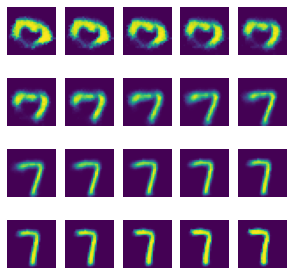

In [ ]:
# fixing dimension 2
outs = dimension_samples_list[1]
fig,axes = plt.subplots(nrows = 4, ncols = 5, figsize=(5,5))
i = 0
for n in range(4):
    for j in range(5):
        axes[n, j].imshow(outs[i].reshape(28, 28).squeeze())
        axes[n, j].axis('off')
        i += 1
fig.show()

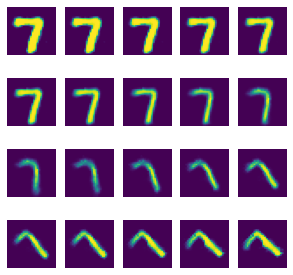

In [ ]:
# fixing dimension 3
outs = dimension_samples_list[2]
fig,axes = plt.subplots(nrows = 4, ncols = 5, figsize=(5,5))
i = 0
for n in range(4):
    for j in range(5):
        axes[n, j].imshow(outs[i].reshape(28, 28).squeeze())
        axes[n, j].axis('off')
        i += 1
fig.show()

Found it! **3rd Dimensiom**
looking at the images, we can see that there is a <u>*gradual effect*</u> of tilting/rotating of 7's. Also, all the <u>*7's look same*</u>. Thus, I believe this is the effect that prof. Kim added to the 

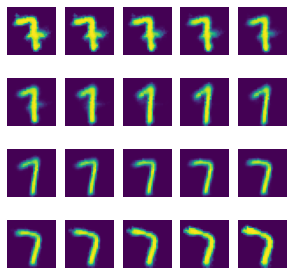

In [ ]:
# fixing dimension 4
outs = dimension_samples_list[3]
fig,axes = plt.subplots(nrows = 4, ncols = 5, figsize=(5,5))
i = 0
for n in range(4):
    for j in range(5):
        axes[n, j].imshow(outs[i].reshape(28, 28).squeeze())
        axes[n, j].axis('off')
        i += 1
fig.show()

Just pointing out that the images from **1st Dimension** also looks like as if the 7's are rotated. However, the gradual effect is clearly seen in images from **3rd dimension**.